Todas las discusiones y comparaciones pertinentes de los resultados que se han considerado pertinentes se realizan en la memoria. En el Notebook se busca explicar el código del que se extraen los resultados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import numpy as np
import re
import ast

In [4]:
dfs = {
    'SBP_MEDIUM': pd.read_csv('SBP_MEDIUM.csv'),   # Resultados base + profundidad 2 + Stockfish
    'SBP_HARD': pd.read_csv('SBP_HARD.csv'),       # Resultados base + profundidad 2 + Stockfish
    'CBP_HARD': pd.read_csv('CBP_HARD.csv'),        # Resultados base + profundidad 2 + Stockfish
}

In [10]:
# Ver las columnas de cada df
for df_name, df in dfs.items():
    print(df_name)
    print(df.columns)

SBP_MEDIUM
Index(['FEN', 'Moves', 'Moves_UCI', 'Puzzle_ID', '9M_results', '136M_results',
       '270M_results', 'stockfish_all_moves_results', '9M_Depth_results',
       'stockfish_all_moves_results_20depth', '136M_Depth_results',
       '270M_Depth_results'],
      dtype='object')
SBP_HARD
Index(['FEN', 'Moves', 'Moves_UCI', '9M_results', '136M_results',
       '270M_results', 'stockfish_all_moves_results', '9M_Depth_results',
       '136M_Depth_results', '270M_Depth_results',
       'stockfish_all_moves_results_20depth'],
      dtype='object')
CBP_HARD
Index(['FEN', 'Moves', 'Moves_UCI', 'Puzzle_ID', '9M_results', '136M_results',
       '270M_results', 'stockfish_all_moves_results', '9M_Depth_results',
       'stockfish_all_moves_results_20depth', '136M_Depth_results',
       '270M_Depth_results'],
      dtype='object')


In [13]:
for df_name, df in dfs.items():
    print(tabulate(df, headers='keys', tablefmt='psql'))

2670089448557), 'cp': -86}, 'a5b7': {'wp': np.float64(0.3031633974307756), 'cp': -226}, 'b6b5': {'wp': np.float64(0.1505507415013339), 'cp': -469}, 'f6e5': {'wp': np.float64(0.14304101506952133), 'cp': -486}, 'f6f5': {'wp': np.float64(0.5130350190228997), 'cp': 14}, 'a7a6': {'wp': np.float64(0.2832167068439501), 'cp': -252}, 'f7d5': {'wp': np.float64(0.09601600454861184), 'cp': -608}, 'f7h5': {'wp': np.float64(0.08028528979471516), 'cp': -662}, 'f7e6': {'wp': np.float64(0.08710622978601217), 'cp': -638}, 'f7g6': {'wp': np.float64(0.4727471101084254), 'cp': -29}, 'f7b7': {'wp': np.float64(0.35372205183273076), 'cp': -163}, 'f7c7': {'wp': np.float64(0.07187483391480849), 'cp': -694}, 'f7d7': {'wp': np.float64(0.08530621703762589), 'cp': -644}, 'f7e7': {'wp': np.float64(0.08107135198373455), 'cp': -659}, 'f7e8': {'wp': np.float64(0.29040849096087273), 'cp': -242}, 'f7g8': {'wp': np.float64(0.33838233247940724), 'cp': -182}, 'g7g5': {'wp': np.float64(0.195301427166539), 'cp': -384}, 'g7g6'

Para cada dataset de resultados se tiene que cada valor de la columna es un diccionario para cada jugada legal:

- Jugada legal

- Puntuación probabilidad

- Puntuación centipeones

Por cada jugada legal, hay dos valores. La jugada que hace el modelo será la de mayor puntuación o probabilidad de victoria

Para cada df primero vamos a almacenar en otra variable la solución

In [7]:
lista_soluciones_por_df = {}

for df_name, df in dfs.items():
    lista_soluciones_por_df[df_name] = df['Moves_UCI'].tolist()

Vamos a crear un dataframe en que cada columna es el id del puzzle, otra el movimiento correcto ('Moves_UCI') y en las otras las valoraciones de los modelos.

In [10]:
def limpiar_y_convertir_a_diccionario(jugada_str):
    """
    Limpia una cadena que representa un diccionario con anotaciones de tipo 'np.float64(...)'
    y la convierte en un diccionario de Python usando `ast.literal_eval`, que es una alternativa segura a `eval`.

    Args:
        jugada_str (str): Cadena que representa un diccionario, posiblemente con valores envueltos como np.float64(...).

    Returns:
        dict o None: El diccionario convertido, o None si ocurre algún error durante la conversión.
    """
    try:
        # Elimina la envoltura de tipo 'np.float64(...)', que puede interferir con la conversión
        jugada_str = jugada_str.replace('np.float64(', '').replace(')', '')
        return ast.literal_eval(jugada_str)  # Conversión segura a estructura de Python
    except Exception as e:
        print("Error al convertir a diccionario:", e)
        return None


def buscar_prob_valorada_por_modelo_segun_real(moves_results, real_moves):
    """
    Dado un conjunto de resultados evaluados por un modelo (en forma de diccionarios serializados) 
    y una lista de jugadas reales (Moves_UCI), extrae la probabilidad ('wp') asignada por el modelo 
    a cada jugada real.

    Args:
        moves_results (pd.Series): Serie con diccionarios en formato string donde cada clave es una jugada
                                   y cada valor es un subdiccionario con estadísticas (por ejemplo, 'wp').
        real_moves (List[str]): Lista de jugadas reales (en formato UCI) que se desean evaluar.

    Returns:
        List[float or None]: Lista con las probabilidades asignadas por el modelo a cada jugada real.
                             Se devuelve None si la jugada no está presente o hay errores de parseo.
    """
    prob = []
    for idx, move in enumerate(real_moves):
        try:
            # Intenta convertir el string en un diccionario válido
            moves_dict = limpiar_y_convertir_a_diccionario(moves_results.iloc[idx])
            if moves_dict is not None and move in moves_dict:
                # Extrae la probabilidad asociada a la jugada real
                prob.append(float(moves_dict[move]['wp']))
            else:
                prob.append(None)  # Jugada no encontrada o diccionario inválido
        except Exception as e:
            print(f"Error procesando move '{move}' en índice {idx}: {e}")
            prob.append(None)
    return prob


def obtener_mejor_jugada(lista_dicts):
    """
    Para cada string que representa un diccionario de jugadas con sus estadísticas,
    identifica cuál es la jugada con mayor probabilidad de victoria ('wp') según el modelo.

    Args:
        lista_dicts (List[str]): Lista de cadenas, cada una representando un diccionario
                                 con jugadas y valores como {'jugada': {'wp': valor}}.

    Returns:
        List[str or None]: Lista de jugadas con mayor 'wp' por cada diccionario.
                           Devuelve None si el diccionario no es válido o está vacío.
    """
    maxs = []
    for jugada in lista_dicts:
        dict_aux = limpiar_y_convertir_a_diccionario(jugada)
        if dict_aux:
            try:
                # Selecciona la jugada cuya probabilidad 'wp' es la mayor del conjunto
                mejor = max(dict_aux.items(), key=lambda x: x[1]['wp'])[0]
                maxs.append(mejor)
            except Exception as e:
                print("Error extrayendo mejor jugada:", e)
                maxs.append(None)
        else:
            maxs.append(None)
    return maxs


In [13]:


valorac_sol_correcta_por_df = {}

for df_name, df in dfs.items():
    # ==================== MODELO 9M ====================
    # Probabilidad de la jugada REAL bajo el modelo 9M_Depth_2
    prob_real_depth2 = buscar_prob_valorada_por_modelo_segun_real(df['9M_Depth_results'], df['Moves_UCI'])

    # Jugada seleccionada por el modelo 9M
    jugada_9M_played = obtener_mejor_jugada(df['9M_results'])

    # Probabilidad que el modelo 9M asignó a la jugada REAL
    prob_real_9M = buscar_prob_valorada_por_modelo_segun_real(df['9M_results'], df['Moves_UCI'])

    # Probabilidad que el modelo 9M le asigna a la jugada HECHA
    prob_made_move = buscar_prob_valorada_por_modelo_segun_real(df['9M_results'], jugada_9M_played)

    # Jugada seleccionada por 9M_Depth_2
    jugada_depth2_played = obtener_mejor_jugada(df['9M_Depth_results'])

    # Probabilidad que el modelo 9M_Depth_2 asignó a la jugada que él mismo eligió
    prob_played_depth2 = buscar_prob_valorada_por_modelo_segun_real(df['9M_Depth_results'], jugada_depth2_played)

    # ==================== MODELO 136M ====================
    prob_real_136M = buscar_prob_valorada_por_modelo_segun_real(df['136M_results'], df['Moves_UCI'])
    jugada_136M_played = obtener_mejor_jugada(df['136M_results'])
    prob_played_136M = buscar_prob_valorada_por_modelo_segun_real(df['136M_results'], jugada_136M_played)

    # ==================== MODELO 136M_Depth ====================
    prob_real_136M_depth = buscar_prob_valorada_por_modelo_segun_real(df['136M_Depth_results'], df['Moves_UCI'])
    jugada_136M_depth_played = obtener_mejor_jugada(df['136M_Depth_results'])
    prob_played_136M_depth = buscar_prob_valorada_por_modelo_segun_real(df['136M_Depth_results'], jugada_136M_depth_played)

    # ==================== MODELO 270M ====================
    prob_real_270M = buscar_prob_valorada_por_modelo_segun_real(df['270M_results'], df['Moves_UCI'])
    jugada_270M_played = obtener_mejor_jugada(df['270M_results'])
    prob_played_270M = buscar_prob_valorada_por_modelo_segun_real(df['270M_results'], jugada_270M_played)

    # ==================== MODELO 270M_Depth ====================
    prob_real_270M_depth = buscar_prob_valorada_por_modelo_segun_real(df['270M_Depth_results'], df['Moves_UCI'])
    jugada_270M_depth_played = obtener_mejor_jugada(df['270M_Depth_results'])
    prob_played_270M_depth = buscar_prob_valorada_por_modelo_segun_real(df['270M_Depth_results'], jugada_270M_depth_played)

    # Probabilidad que Stockfish asigna a la jugada real
    prob_real_st_all = buscar_prob_valorada_por_modelo_segun_real(df['stockfish_all_moves_results'], df['Moves_UCI'])

    # Probabilidad que Stockfish de prof 20 asigna a la jugada real
#    prob_real_st_20 = buscar_prob_valorada_por_modelo_segun_real(df['stockfish_20_results'], df['Moves_UCI'])

    valorac_sol_correcta_por_df[df_name] = {
        'FEN': df['FEN'],
        'Moves_UCI': df['Moves_UCI'],
        '9M_move_played': jugada_9M_played,
        '9M_prob_played': prob_made_move,
        '9M_prob_real': prob_real_9M,
        '9M_Depth_2_move_played': jugada_depth2_played,
        '9M_Depth_2_prob_played': prob_played_depth2,
        '9M_Depth_2_prob_real': prob_real_depth2,
        'St_all_moves_prob_real': prob_real_st_all,
#        'St_20_prob_real': prob_real_st_20,
        '136M_move_played': jugada_136M_played,
        '136M_prob_played': prob_played_136M,
        '136M_prob_real': prob_real_136M,
        '136M_Depth_move_played': jugada_136M_depth_played,
        '136M_Depth_prob_played': prob_played_136M_depth,
        '136M_Depth_prob_real': prob_real_136M_depth,
        '270M_move_played': jugada_270M_played,
        '270M_prob_played': prob_played_270M,
        '270M_prob_real': prob_real_270M,
        '270M_Depth_move_played': jugada_270M_depth_played,
        '270M_Depth_prob_played': prob_played_270M_depth,
        '270M_Depth_prob_real': prob_real_270M_depth
    }

valorac_df = pd.DataFrame(valorac_sol_correcta_por_df[df_name])


In [9]:
for df_name,df in valorac_sol_correcta_por_df.items():
    print(df_name)
    print(tabulate(df, headers='keys', tablefmt='psql'))

SBP_MEDIUM
+-----------------------------------------------------------------------+-------------+------------------+------------------+----------------+--------------------------+--------------------------+------------------------+--------------------------+--------------------+--------------------+------------------+--------------------------+--------------------------+------------------------+--------------------+--------------------+------------------+--------------------------+--------------------------+------------------------+
| FEN                                                                   | Moves_UCI   | 9M_move_played   |   9M_prob_played |   9M_prob_real | 9M_Depth_2_move_played   |   9M_Depth_2_prob_played |   9M_Depth_2_prob_real |   St_all_moves_prob_real | 136M_move_played   |   136M_prob_played |   136M_prob_real | 136M_Depth_move_played   |   136M_Depth_prob_played |   136M_Depth_prob_real | 270M_move_played   |   270M_prob_played |   270M_prob_real | 270M_Depth

Lo anterior, pero desglosado puzzle por puzzle: cada diccionario debe estar asociado a un puzzle concreto, y las columnas deben incluir: (i) la jugada valorada por el modelo con mayor puntuación (ordenada decrecientemente según el modelo 9M_Depth), (ii) la jugada solución (real), y (iii) la probabilidad que asigna cada modelo a la jugada de la primera columna.

In [16]:
puzzles_valorados = {}

for df_name, df in dfs.items():
    for idx in range(len(df)):
        try:
            jugadas_9M = limpiar_y_convertir_a_diccionario(df['9M_results'].iloc[idx])
            jugadas_9M_Depth = limpiar_y_convertir_a_diccionario(df['9M_Depth_results'].iloc[idx])
            jugadas_136M = limpiar_y_convertir_a_diccionario(df['136M_results'].iloc[idx])
            jugadas_136M_Depth = limpiar_y_convertir_a_diccionario(df['136M_Depth_results'].iloc[idx])
            jugadas_270M = limpiar_y_convertir_a_diccionario(df['270M_results'].iloc[idx])
            jugadas_270M_Depth = limpiar_y_convertir_a_diccionario(df['270M_Depth_results'].iloc[idx])
            jugadas_St = limpiar_y_convertir_a_diccionario(df['stockfish_all_moves_results'].iloc[idx])

            if not jugadas_9M_Depth:
                continue  # no hay movimientos, saltar

            # Ordenar por wp descendente según cada modelo
            orden_9M = sorted(jugadas_9M.items(), key=lambda x: x[1]['wp'], reverse=True) if jugadas_9M else []
            orden_9M_Depth = sorted(jugadas_9M_Depth.items(), key=lambda x: x[1]['wp'], reverse=True)
            orden_136M = sorted(jugadas_136M.items(), key=lambda x: x[1]['wp'], reverse=True) if jugadas_136M else []
            orden_136M_Depth = sorted(jugadas_136M_Depth.items(), key=lambda x: x[1]['wp'], reverse=True) if jugadas_136M_Depth else []
            orden_270M = sorted(jugadas_270M.items(), key=lambda x: x[1]['wp'], reverse=True) if jugadas_270M else []
            orden_270M_Depth = sorted(jugadas_270M_Depth.items(), key=lambda x: x[1]['wp'], reverse=True) if jugadas_270M_Depth else []
            orden_St = sorted(jugadas_St.items(), key=lambda x: x[1]['wp'], reverse=True) if jugadas_St else []

            total_moves = len(orden_9M_Depth)
            real_move = df['Moves_UCI'].iloc[idx]

            moves_valorados = []

            for i, (move, info) in enumerate(orden_9M_Depth):
                # Obtener probabilidades
                wp_9M = float(jugadas_9M.get(move, {}).get('wp', None)) if jugadas_9M else None
                wp_9M_Depth = float(info['wp'])
                wp_136M = float(jugadas_136M.get(move, {}).get('wp', None)) if jugadas_136M else None
                wp_136M_Depth = float(jugadas_136M_Depth.get(move, {}).get('wp', None)) if jugadas_136M_Depth else None
                wp_270M = float(jugadas_270M.get(move, {}).get('wp', None)) if jugadas_270M else None
                wp_270M_Depth = float(jugadas_270M_Depth.get(move, {}).get('wp', None)) if jugadas_270M_Depth else None
                wp_St = float(jugadas_St.get(move, {}).get('wp', None)) if jugadas_St else None

                # Rankings por modelo (por defecto None si no encontrado)
                rank_9M = next((j for j, (m, _) in enumerate(orden_9M) if m == move), None)
                rank_9M_Depth = i
                rank_136M = next((j for j, (m, _) in enumerate(orden_136M) if m == move), None)
                rank_136M_Depth = next((j for j, (m, _) in enumerate(orden_136M_Depth) if m == move), None)
                rank_270M = next((j for j, (m, _) in enumerate(orden_270M) if m == move), None)
                rank_270M_Depth = next((j for j, (m, _) in enumerate(orden_270M_Depth) if m == move), None)
                rank_St = next((j for j, (m, _) in enumerate(orden_St) if m == move), None)

                move_info = {
                    'move': move,
                    'solution_move': real_move,
                    'wp_9M': wp_9M,
                    'wp_9M_Depth': wp_9M_Depth,
                    'wp_136M': wp_136M,
                    'wp_136M_Depth': wp_136M_Depth,
                    'wp_270M': wp_270M,
                    'wp_270M_Depth': wp_270M_Depth,
                    'wp_St': wp_St,

                    'diff_St_vs_9M': wp_St - wp_9M if wp_St is not None and wp_9M is not None else None,
                    'diff_St_vs_9M_Depth': wp_St - wp_9M_Depth if wp_St is not None and wp_9M_Depth is not None else None,
                    'diff_St_vs_136M': wp_St - wp_136M if wp_St is not None and wp_136M is not None else None,
                    'diff_St_vs_136M_Depth': wp_St - wp_136M_Depth if wp_St is not None and wp_136M_Depth is not None else None,
                    'diff_St_vs_270M': wp_St - wp_270M if wp_St is not None and wp_270M is not None else None,
                    'diff_St_vs_270M_Depth': wp_St - wp_270M_Depth if wp_St is not None and wp_270M_Depth is not None else None,

                    'rank_9M': f"{rank_9M+1} de {len(orden_9M)}" if rank_9M is not None else None,
                    'rank_9M_Depth': f"{rank_9M_Depth+1} de {total_moves}",
                    'rank_136M': f"{rank_136M+1} de {len(orden_136M)}" if rank_136M is not None else None,
                    'rank_136M_Depth': f"{rank_136M_Depth+1} de {len(orden_136M_Depth)}" if rank_136M_Depth is not None else None,
                    'rank_270M': f"{rank_270M+1} de {len(orden_270M)}" if rank_270M is not None else None,
                    'rank_270M_Depth': f"{rank_270M_Depth+1} de {len(orden_270M_Depth)}" if rank_270M_Depth is not None else None,
                    'rank_St': f"{rank_St+1} de {len(orden_St)}" if rank_St is not None else None,
                }

                moves_valorados.append(move_info)

            puzzles_valorados[(df_name, idx)] = moves_valorados

        except Exception as e:
            print(f"Error procesando puzzle {idx} en {df_name}: {e}")



In [43]:
for df_name, df in puzzles_valorados.items():
    if df_name[0] == 'SBP_MEDIUM' and df_name[1] < 10:  # solo los primeros 10 puzzles
        print(f"\nPuzzle {df_name[1]} de {df_name[0]}")
        print(tabulate(df, headers='keys', tablefmt='psql'))



Puzzle 0 de SBP_MEDIUM
+--------+-----------------+-----------+---------------+-----------+-----------------+-----------+-----------------+-----------+-----------------+-----------------------+-------------------+-------------------------+-------------------+-------------------------+-----------+-----------------+-------------+-------------------+-------------+-------------------+-----------+
| move   | solution_move   |     wp_9M |   wp_9M_Depth |   wp_136M |   wp_136M_Depth |   wp_270M |   wp_270M_Depth |     wp_St |   diff_St_vs_9M |   diff_St_vs_9M_Depth |   diff_St_vs_136M |   diff_St_vs_136M_Depth |   diff_St_vs_270M |   diff_St_vs_270M_Depth | rank_9M   | rank_9M_Depth   | rank_136M   | rank_136M_Depth   | rank_270M   | rank_270M_Depth   | rank_St   |
|--------+-----------------+-----------+---------------+-----------+-----------------+-----------+-----------------+-----------+-----------------+-----------------------+-------------------+-------------------------+--------------

Ahora vamos a recoger la jugada que haría cada modelo cuyos resultados están recogidos en los dataframes.

In [13]:
columnas_por_modelo = {
    '9M': '9M_results',
    '136M': '136M_results',
    '270M': '270M_results',
    '9M_Depth_2': '9M_Depth_results',
    '136M_Depth_2': '136M_Depth_results',
    '270M_Depth_2': '270M_Depth_results',
    'St_all_moves': 'stockfish_all_moves_results',
    'St_20depth': 'stockfish_all_moves_results_20depth'
    
}

# Inicializar estructura para almacenar jugadas por modelo
jugadas_por_modelo = {modelo: {} for modelo in columnas_por_modelo}

# Función para limpiar y convertir cadenas que representan diccionarios con valores tipo 'np.float64(...)'
def limpiar_y_convertir_a_diccionario(cadena):
    """
    Limpia una cadena de texto que representa un diccionario serializado, 
    reemplazando las envolturas tipo 'np.float64(...)' por su valor numérico crudo, 
    y luego convierte la cadena limpia en un diccionario de Python.

    Este tipo de formato suele aparecer al serializar resultados numéricos de modelos 
    en estructuras de texto (por ejemplo, al guardar DataFrames como CSV).

    Args:
        cadena (str): Cadena de texto que contiene un diccionario con anotaciones de tipo NumPy.

    Returns:
        dict o None: Diccionario válido si la conversión tiene éxito; None si ocurre un error.
    """
    try:
        # Sustituye expresiones tipo 'np.float64(0.123)' por '0.123' usando expresiones regulares
        cadena_limpia = re.sub(r'np\.float64\(([0-9eE\.\-+]+)\)', r'\1', cadena)

        # Convierte la cadena limpia a diccionario (uso seguro de literal_eval en lugar de eval)
        return ast.literal_eval(cadena_limpia)
    except Exception as e:
        # Captura errores de sintaxis o formato y devuelve None
        print("Error al limpiar y convertir:", e)
        return None


# Iterar sobre los DataFrames y calcular jugadas por modelo
for df_name, df in dfs.items():
    for modelo, columna in columnas_por_modelo.items():
        if columna in df.columns:
            jugadas_por_modelo[modelo][df_name] = obtener_mejor_jugada(df[columna])
        else:
            jugadas_por_modelo[modelo][df_name] = None



Dado que ya tenemos la jugada que haría cada modelo, podemos calcular el accuracy de cada modelo.

In [16]:
acc_por_modelo = {modelo: {} for modelo in jugadas_por_modelo.keys()}

# Calculamos precisión por modelo y por DataFrame
for modelo in jugadas_por_modelo:
    for df_name, jugadas_predichas in jugadas_por_modelo[modelo].items():
        if jugadas_predichas is None or df_name not in dfs:
            acc_por_modelo[modelo][f"{df_name}_{modelo}"] = None
            continue

        true_moves = dfs[df_name]['Moves_UCI']
        
        # Aseguramos que las longitudes coincidan
        if len(true_moves) != len(jugadas_predichas):
            print(f"Longitud distinta en {df_name} ({modelo})")
            acc_por_modelo[modelo][f"{df_name}_{modelo}"] = None
            continue

        acc = (true_moves == jugadas_predichas).mean()
        acc_por_modelo[modelo][f"{df_name}_{modelo}"] = acc

In [19]:
from tabulate import tabulate

# Construimos la tabla: df_name -> modelo -> accuracy
acc_tabla = {}

for modelo, accs in acc_por_modelo.items():
    for df_tag, valor in accs.items():
        # Extraer el nombre real del dataset (sin sufijo)
        df_name = df_tag.replace(f'_{modelo}', '')
        if df_name not in acc_tabla:
            acc_tabla[df_name] = {}
        acc_tabla[df_name][modelo] = valor

# Obtener lista completa de modelos para mantener orden
todos_los_modelos = sorted(acc_por_modelo.keys())

# Encabezados para la tabla
headers = ['df_name'] + todos_los_modelos
rows = []

# Construimos cada fila para la tabla
for df_name in sorted(acc_tabla.keys()):
    row = [df_name]
    for modelo in todos_los_modelos:
        val = acc_tabla[df_name].get(modelo)
        row.append(round(val, 3) if isinstance(val, float) else val)
    rows.append(row)

# Mostrar tabla con tabulate
print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))


╒════════════╤════════╤════════════════╤════════╤════════════════╤═══════╤══════════════╤══════════════╤════════════════╕
│ df_name    │   136M │   136M_Depth_2 │   270M │   270M_Depth_2 │    9M │   9M_Depth_2 │   St_20depth │   St_all_moves │
╞════════════╪════════╪════════════════╪════════╪════════════════╪═══════╪══════════════╪══════════════╪════════════════╡
│ CBP_HARD   │  0.44  │          0.598 │  0.488 │          0.679 │ 0.354 │        0.55  │        0.952 │          0.89  │
├────────────┼────────┼────────────────┼────────┼────────────────┼───────┼──────────────┼──────────────┼────────────────┤
│ SBP_HARD   │  0.611 │          0.751 │  0.635 │          0.764 │ 0.518 │        0.666 │        0.811 │          0.78  │
├────────────┼────────┼────────────────┼────────┼────────────────┼───────┼──────────────┼──────────────┼────────────────┤
│ SBP_MEDIUM │  0.618 │          0.803 │  0.671 │          0.829 │ 0.539 │        0.75  │        0.816 │          0.763 │
╘════════════╧════════╧═

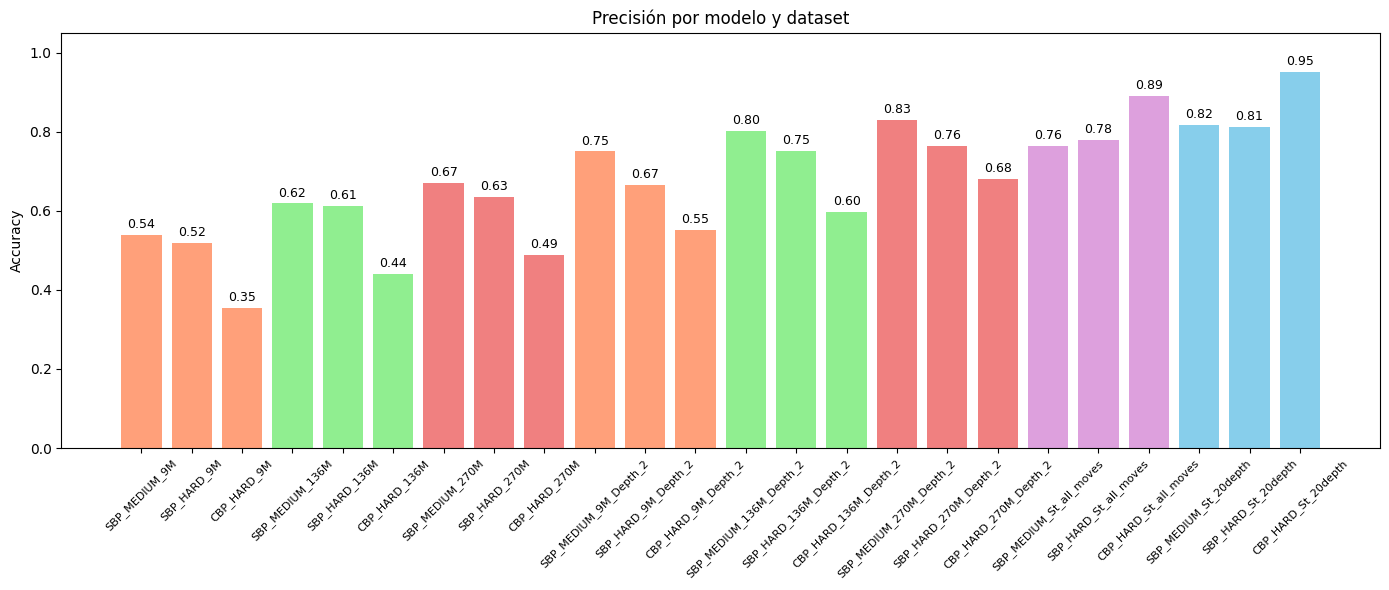

In [22]:
from matplotlib.patches import Patch

acc_all = {}

# Construimos el diccionario acc_all
for modelo, accs in acc_por_modelo.items():
    for df_tag, valor in accs.items():
        acc_all[df_tag] = valor

# Filtramos los valores None
acc_all = {k: v for k, v in acc_all.items() if v is not None}

labels = list(acc_all.keys())
values = list(acc_all.values())

# Función para asignar color según si contiene ciertas cadenas
def asignar_color(label):
    if "9M" in label:
        return "lightsalmon"    
    elif "136M" in label:
        return "lightgreen"    
    elif "270M" in label:
        return "lightcoral"     
    elif "St_all_moves" in label:
        return "plum"           
    elif "St_20depth" in label:
        return "skyblue"        
    else:
        return "lightgray"      

colors = [asignar_color(label) for label in labels]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(labels, values, color=colors)

# Etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.01,
             f'{height:.2f}',
             ha='center',
             va='bottom',
             fontsize=9)

plt.ylabel('Accuracy')
plt.xticks(rotation=45, fontsize=8)
plt.title('Precisión por modelo y dataset')
plt.ylim(0, 1.05)
plt.tight_layout()

# Leyenda
legend_elements = [
    Patch(facecolor='lightsalmon', label='9M*'),
    Patch(facecolor='lightgreen', label='136M*'),
    Patch(facecolor='lightcoral', label='270M*'),
    Patch(facecolor='plum', label='St_all_moves'),
    Patch(facecolor='skyblue', label='St_20depth'),
    Patch(facecolor='lightgray', label='Otros'),
]
#plt.legend(handles=legend_elements, title="Categorías", loc='upper right')

plt.show()

Se sigue viendo la distribución de probabilidades de victoria de cada modelo mediante un histograma. Por cada dataset y por cada modelo, se visualiza un histograma

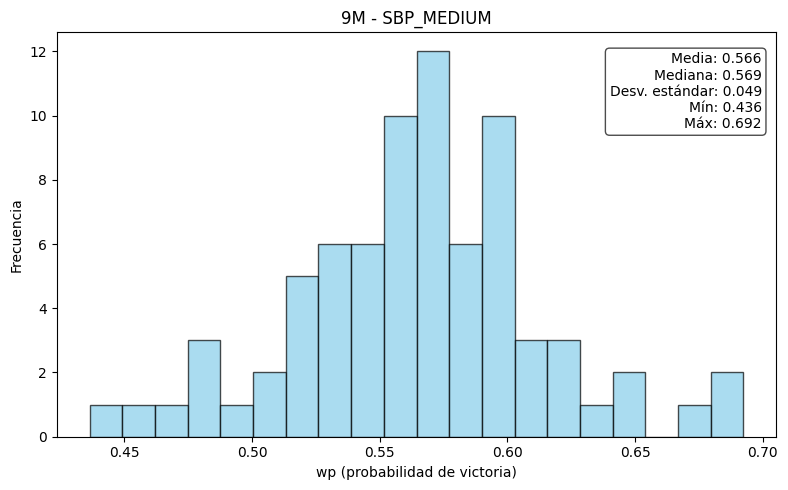

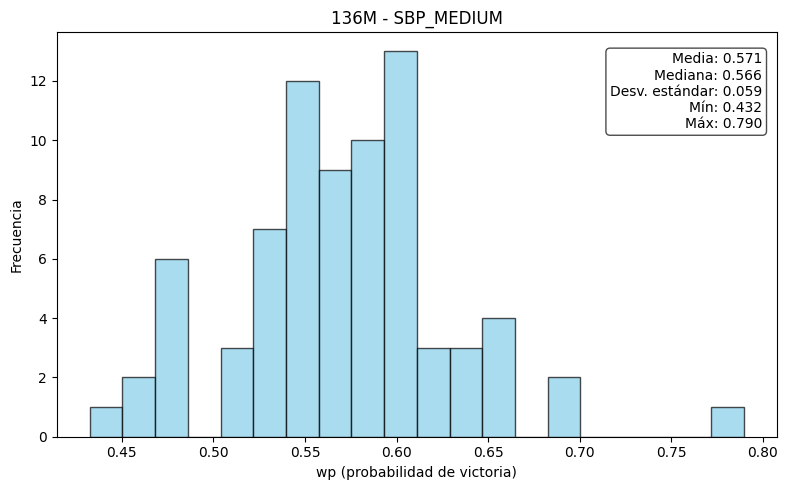

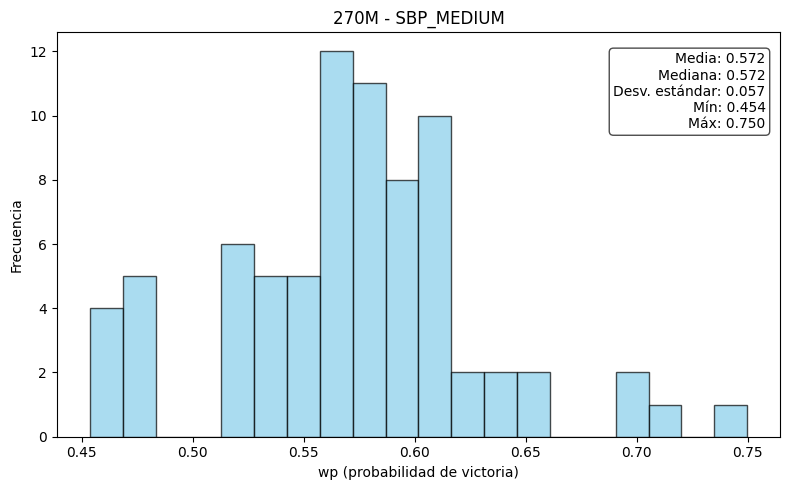

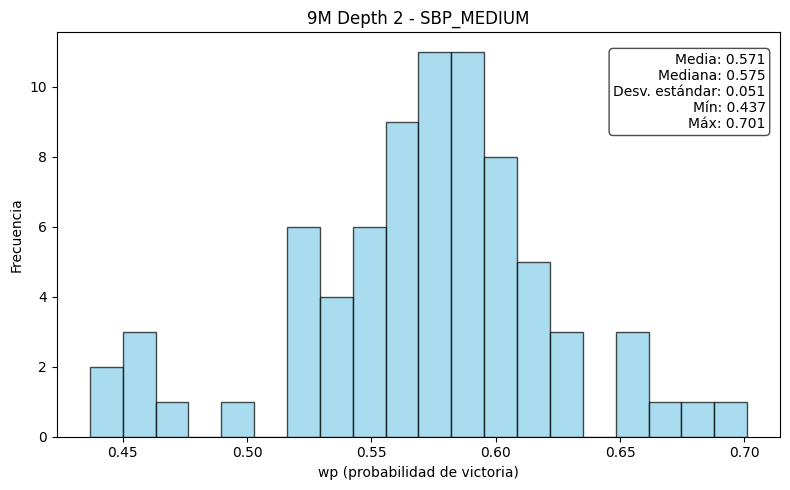

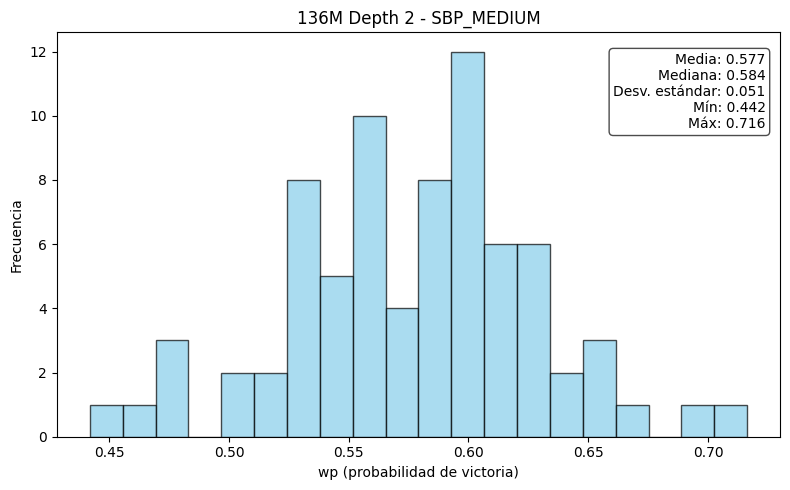

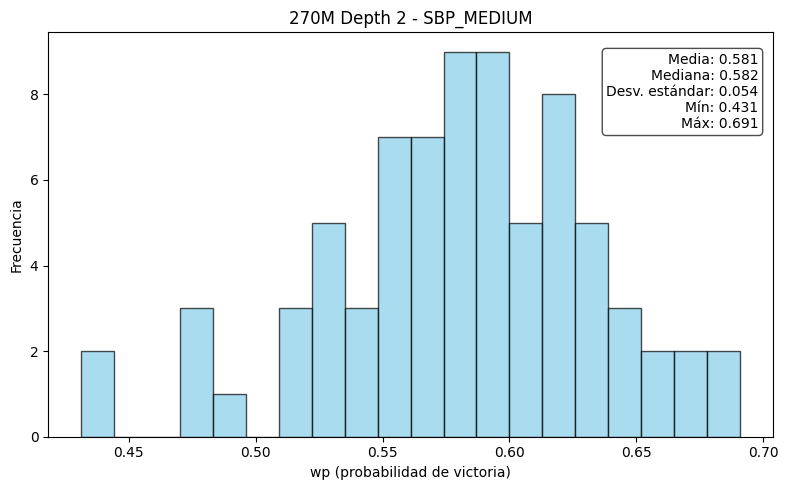

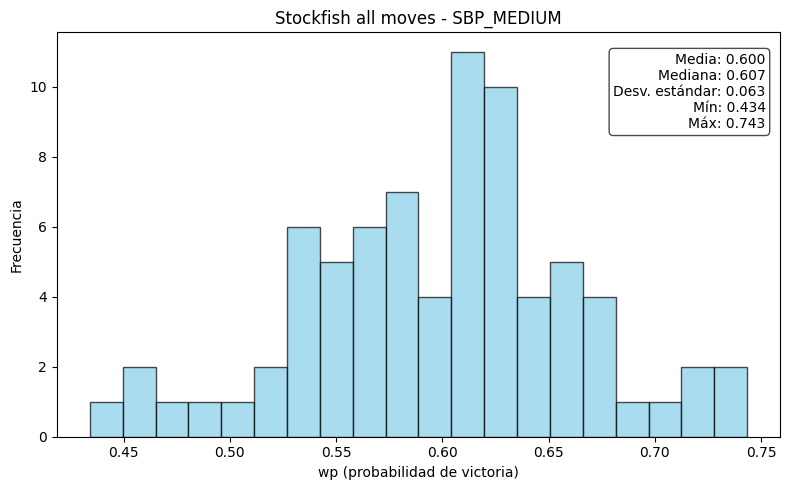

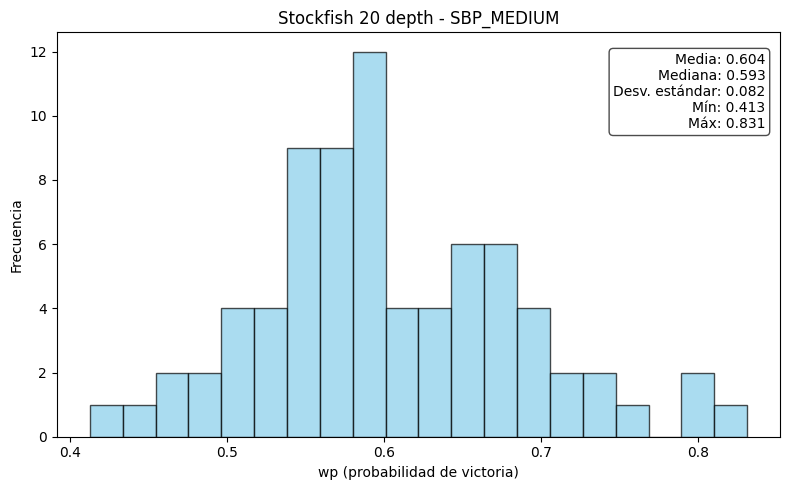

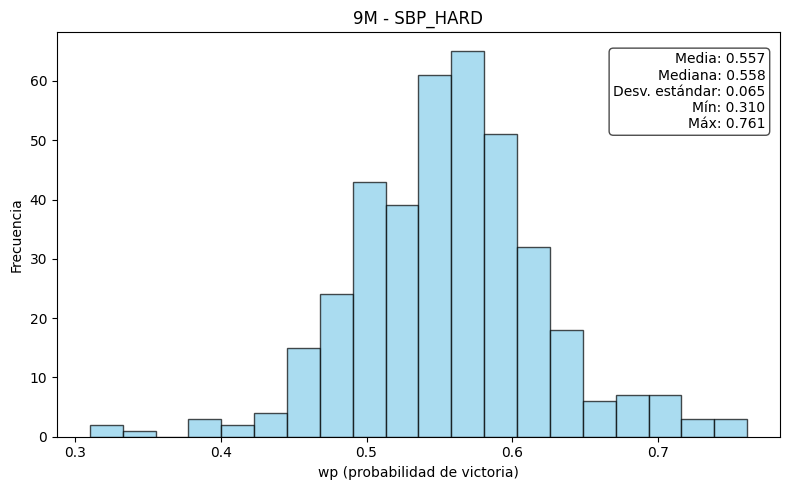

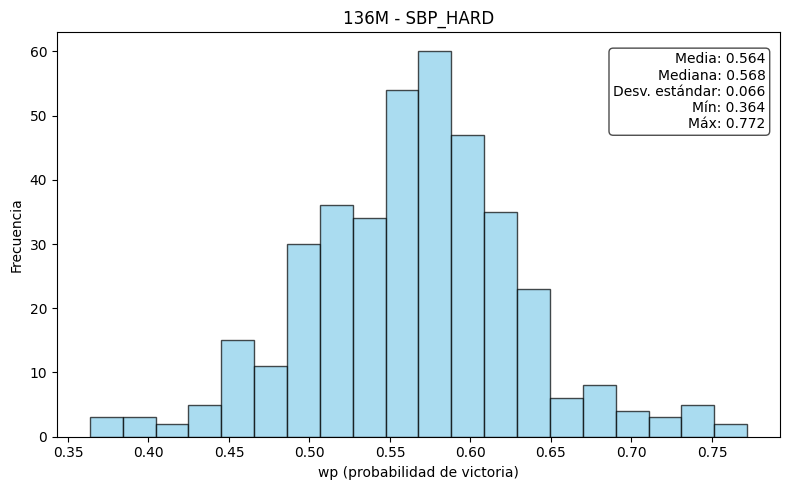

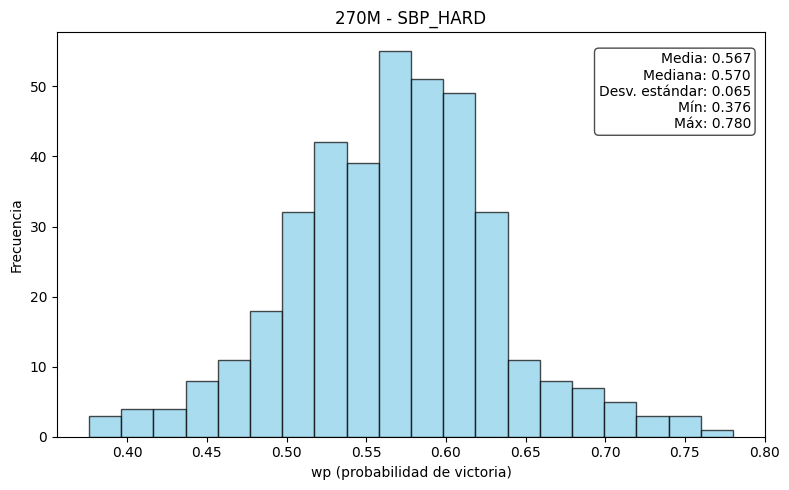

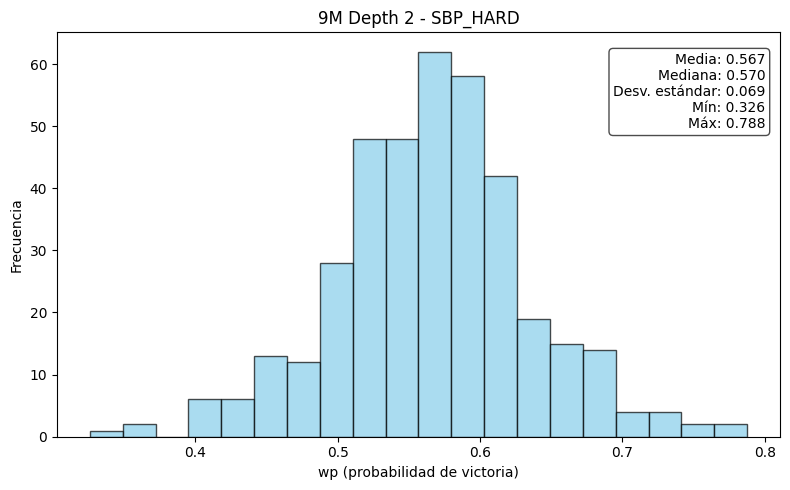

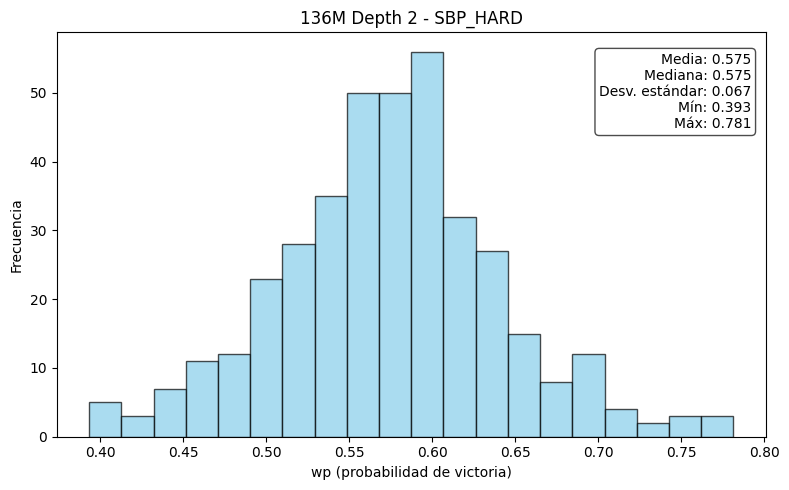

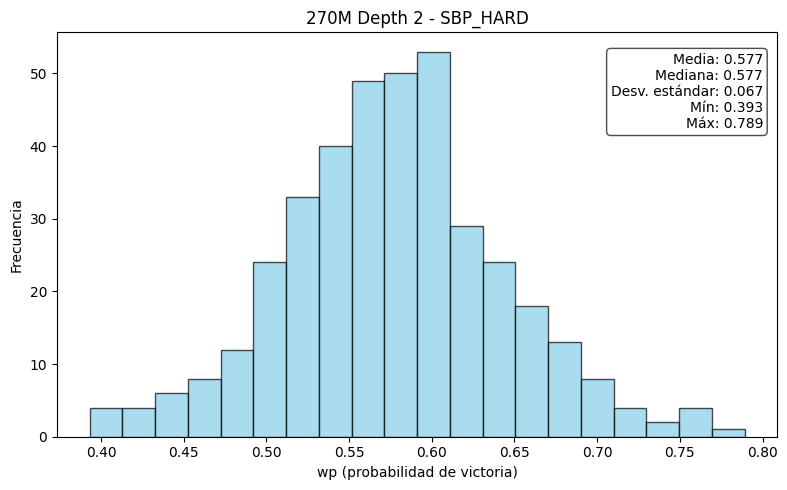

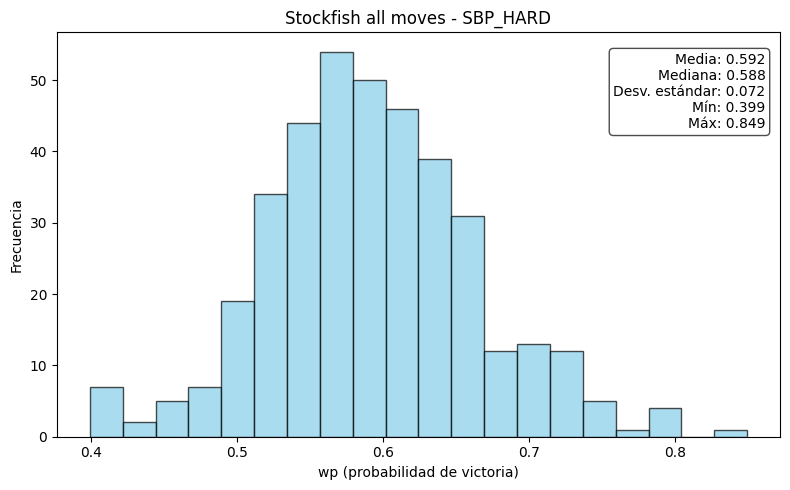

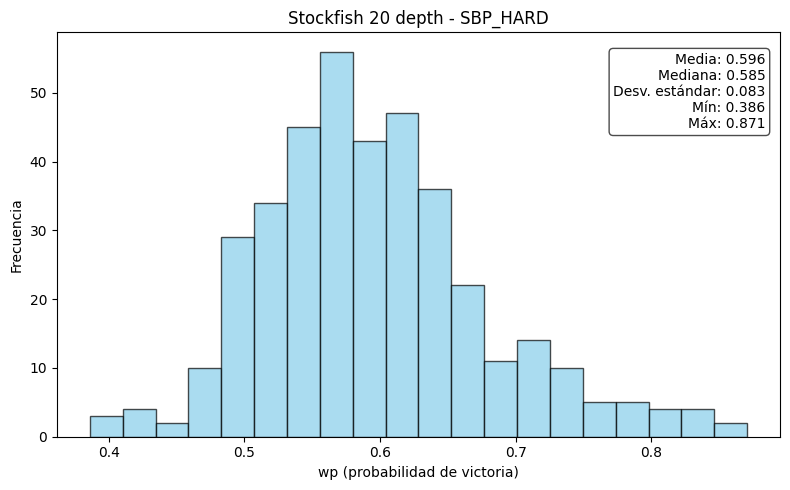

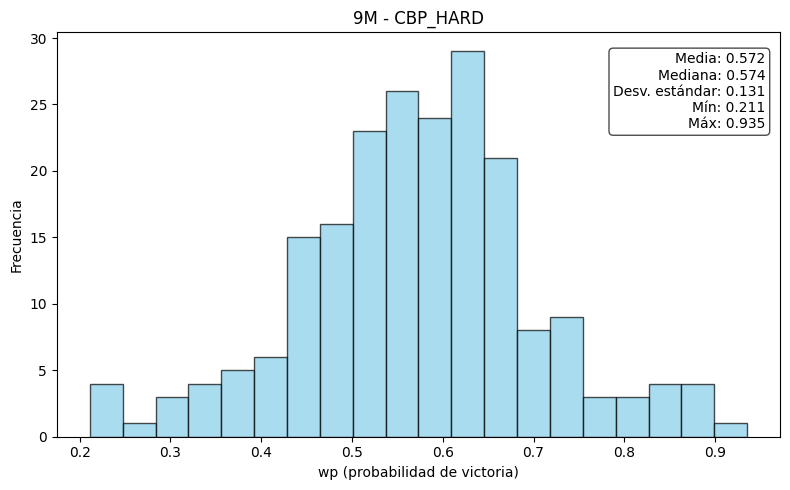

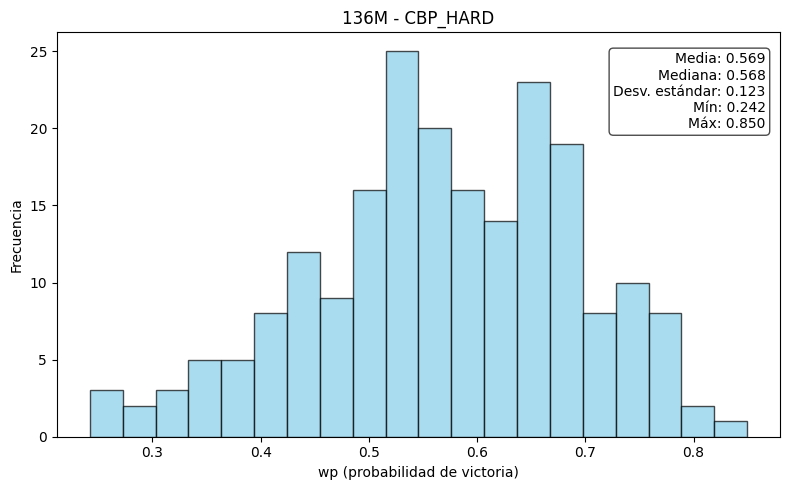

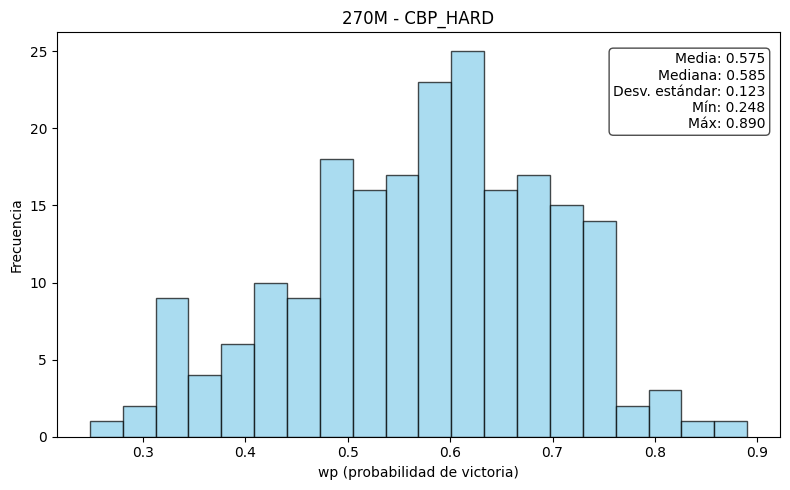

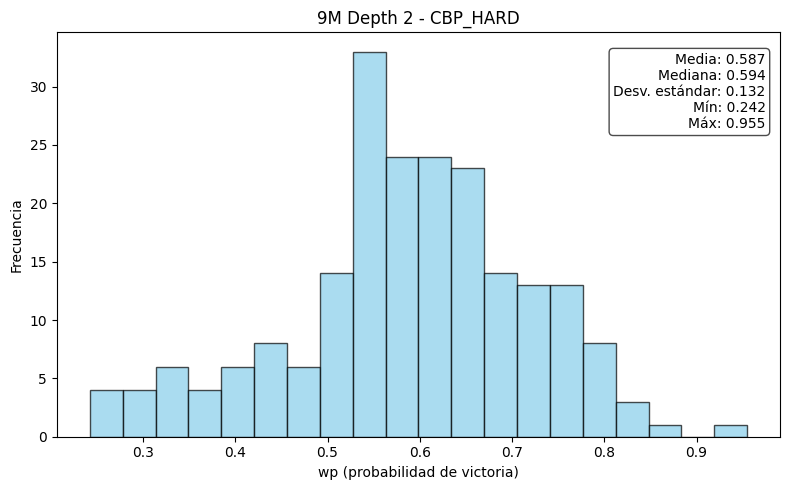

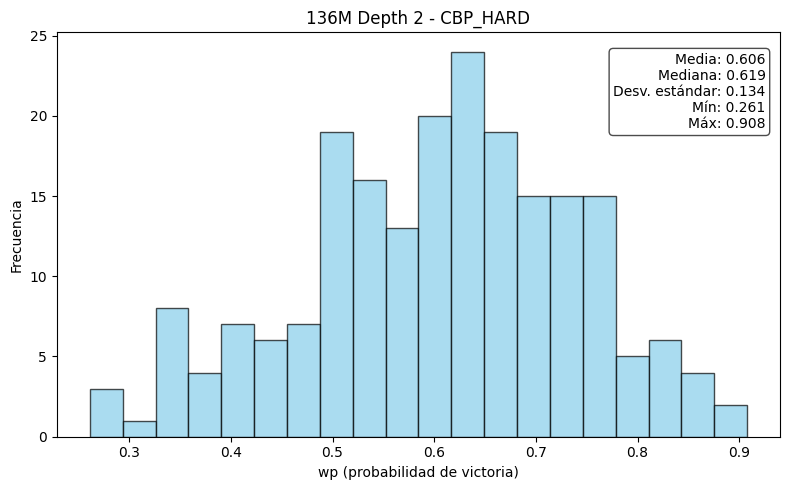

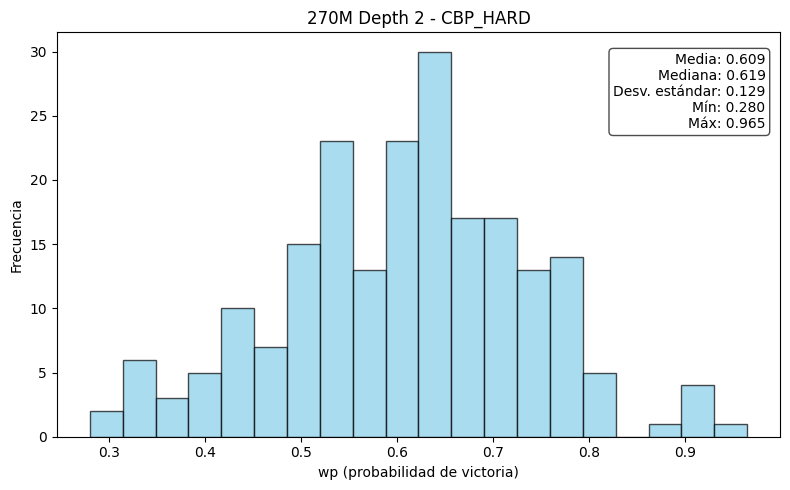

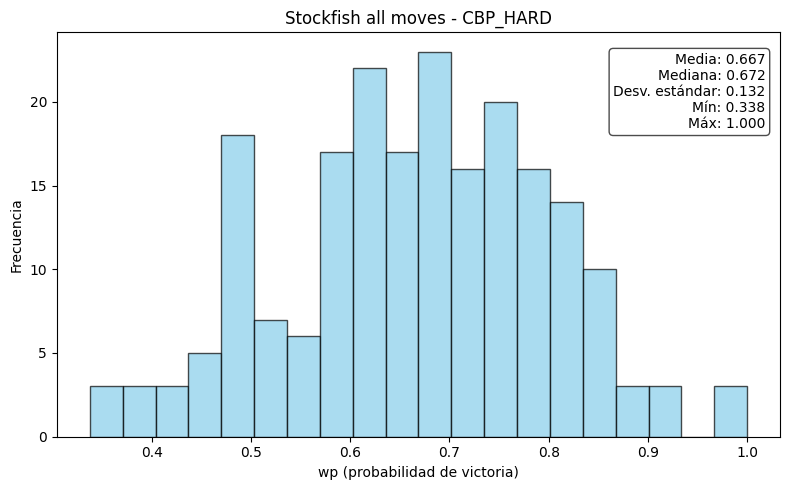

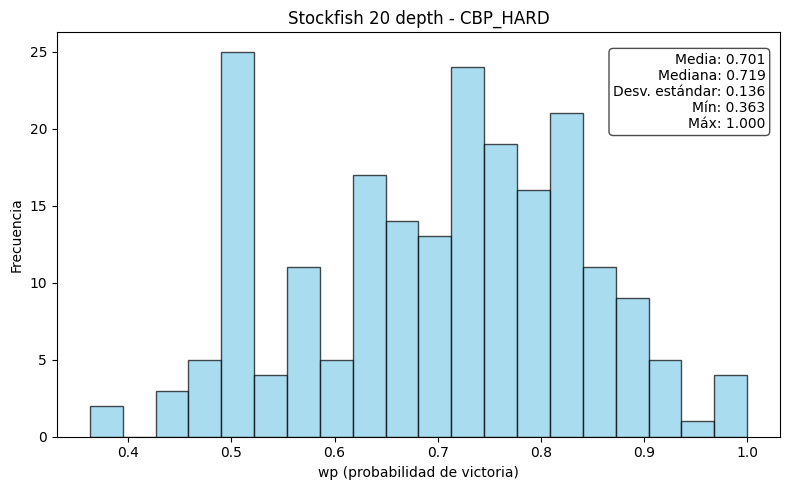

In [23]:
def obtener_probabilidades(lista_dicts):
    """
    Extrae la probabilidad de victoria ('wp') asociada a la mejor jugada (la que tiene mayor 'wp')
    de cada diccionario en una lista de jugadas evaluadas.

    Esta función asume que cada elemento de la lista es una cadena que representa un diccionario 
    con jugadas como claves y subdiccionarios como valores, donde uno de los campos es 'wp'.

    Args:
        lista_dicts (List[str]): Lista de cadenas, cada una representando un diccionario de jugadas
                                 con estructura {'jugada': {'wp': valor}}.

    Returns:
        List[float]: Lista de probabilidades 'wp' correspondientes a la mejor jugada de cada puzzle.
                     Se eliminan los valores `None` que pueden surgir por errores de parseo o estructura.
    """
    maxs = []
    for jugada in lista_dicts:
        # Convertir string a diccionario limpio
        dict_aux = limpiar_y_convertir_a_diccionario(jugada)
        if dict_aux is not None:
            try:
                # Obtener la mayor probabilidad 'wp' entre todas las jugadas del diccionario
                max_wp = max(dict_aux.items(), key=lambda x: x[1]['wp'])[1]['wp']
                maxs.append(max_wp)
            except Exception as e:
                print(f"Error extrayendo wp: {e}")
                maxs.append(None)
        else:
            maxs.append(None)
    
    # Se eliminan los valores None (errores de parseo o diccionarios vacíos)
    return [x for x in maxs if x is not None]


# Graficar los histogramas para cada modelo en cada dataframe
for df_name, df in dfs.items():
    modelos = {
        '9M': df.get('9M_results'),
        '136M': df.get('136M_results'),
        '270M': df.get('270M_results'),
        '9M Depth 2': df.get('9M_Depth_results'),
        '136M Depth 2': df.get('136M_Depth_results'),
        '270M Depth 2': df.get('270M_Depth_results'),
        'Stockfish all moves': df.get('stockfish_all_moves_results'),
        'Stockfish 20 depth': df.get('stockfish_all_moves_results_20depth') if 'stockfish_all_moves_results_20depth' in df.columns else None
    }

    for modelo_nombre, columna in modelos.items():
        if columna is None:
            print(f"[{df_name} - {modelo_nombre}] Columna no disponible. Saltando.")
            continue

        probabilidades = obtener_probabilidades(columna)

        if len(probabilidades) == 0:
            print(f"[{df_name} - {modelo_nombre}] No se encontraron probabilidades válidas.")
            continue

        # Calcular estadísticos
        media = np.mean(probabilidades)
        mediana = np.median(probabilidades)
        std = np.std(probabilidades)
        minimo = np.min(probabilidades)
        maximo = np.max(probabilidades)

        plt.figure(figsize=(8, 5))
        plt.hist(probabilidades, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"{modelo_nombre} - {df_name}")
        plt.xlabel("wp (probabilidad de victoria)")
        plt.ylabel("Frecuencia")

        # Texto con los estadísticos
        stats_text = (f"Media: {media:.3f}\n"
                      f"Mediana: {mediana:.3f}\n"
                      f"Desv. estándar: {std:.3f}\n"
                      f"Mín: {minimo:.3f}\n"
                      f"Máx: {maximo:.3f}")

        plt.text(0.98, 0.95, stats_text,
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

        plt.tight_layout()
        plt.show()

Procedemos a buscar los puzzles en los que falla cada modelo Transformer para hacer un análisis de las distribuciones de las diferencias de probabilidades con Stockfish de profundidad 20, que es el que da mejores resultados.

In [43]:
# Ahora vamos a coger los puzzles en los que falle LST. que son los que Moves_UCI es distinto a la mejor jugada
# de las calculadas antes. Lo que haremos será quedarnos con esas filas y el dato correspondiente al movimiento
# El objetivo es después tratar las probabilidades, wp, asociadas a cada movimiento hecho
puzzles_fallados_por_modelo = {
    '9M': {},
    '136M': {},
    '270M': {},
  #  '9M_Depth_2': {}, 
  #  '136M_Depth_2': {},
  #  '270M_Depth_2': {},
    'St_all_moves': {},
    'St_20depth': {}
}

for df_name, df in dfs.items():
    for modelo in list(puzzles_fallados_por_modelo.keys()):  # Convertimos las keys a lista para evitar modificación durante iteración
        if modelo not in jugadas_por_modelo:  # Verificamos que el modelo existe en jugadas_por_modelo
            print(f"Advertencia: El modelo {modelo} no está en jugadas_por_modelo")
            continue
            
        jugadas_predichas = jugadas_por_modelo[modelo].get(df_name)

        if jugadas_predichas is None:
            puzzles_fallados_por_modelo[modelo][df_name] = None
            continue

        # Comparamos la jugada real vs la predicha
        fallos = df[df['Moves_UCI'] != jugadas_predichas]
        puzzles_fallados_por_modelo[modelo][df_name] = fallos


A continuación, por cada puzzle de cada dataset que falla cada modelo, extraemos las probabilidades de victoria, wp, asociada a cada modelo respectivamente, junto a las de Stockfish con tiempo 0.05s y Stockfish con profundidad 20

In [46]:


# Diccionario centralizado con las probabilidades de victoria por modelo y por df, solo en puzzles fallados
probs_victoria_por_modelo = {
    '9M': {},
    '136M': {},
    '270M': {},
   # '9M_Depth_2': {},
   # '136M_Depth_2': {},
   # '270M_Depth_2': {},
    'St0.05': {},
    'St_pr20': {}
}

# Asociamos columnas a los modelos
columnas_por_modelo = {
    '9M': '9M_results',
    '136M': '136M_results',
    '270M': '270M_results',
  #  '9M_Depth_2': '9M_Depth_results',
  #  '136M_Depth_2': '136M_Depth_results',
  #  '270M_Depth_2': '270M_Depth_results',
    'St0.05': 'stockfish_all_moves_results',
    'St_pr20': 'stockfish_all_moves_results_20depth'
}

modelo_mapping = {
    '9M': '9M',
    '136M': '136M', 
    '270M': '270M',
#    '9M_Depth_2': '9M_Depth_2',
#    '136M_Depth_2': '136M_Depth_2',
#    '270M_Depth_2': '270M_Depth_2',
    'St_all_moves': 'St0.05',
    'St_20depth': 'St_pr20'
}

for modelo_original, puzzles_por_df in puzzles_fallados_por_modelo.items():
    # Obtenemos el nombre mapeado del modelo
    modelo = modelo_mapping.get(modelo_original)
    
    if modelo is None:  # Si no existe mapeo, continuamos con el siguiente
        continue
        
    for df_name, df_fallos in puzzles_por_df.items():
        if df_fallos is None or columnas_por_modelo.get(modelo) not in df_fallos.columns:
            probs_victoria_por_modelo[modelo][df_name] = None
            continue

        columna = columnas_por_modelo[modelo]
        lista_dicts = df_fallos[columna]
        probs_victoria_por_modelo[modelo][df_name] = obtener_probabilidades(lista_dicts)


Para comenzar con el análisis comparativo entre los modelos y Stockfish en sus variantes podemos hacer una comparación de medias de probabilidades.

In [49]:
tabla_resultados = {}

for modelo, resultados_por_df in probs_victoria_por_modelo.items():
    for df_name, lista_probs in resultados_por_df.items():
        if df_name not in tabla_resultados:
            tabla_resultados[df_name] = {}
        
        if lista_probs is None or len(lista_probs) == 0:
            promedio = None
        else:
            promedio = np.mean(lista_probs)
        
        tabla_resultados[df_name][modelo] = promedio

# Preparar headers y filas para tabulate
modelos = list(probs_victoria_por_modelo.keys())
headers = ['df_name'] + modelos
filas = []

for df_name in sorted(tabla_resultados.keys()):
    fila = [df_name]
    for modelo in modelos:
        valor = tabla_resultados[df_name].get(modelo, None)
        fila.append(round(valor, 3) if isinstance(valor, float) else valor)
    filas.append(fila)

# Mostrar tabla
print(tabulate(filas, headers=headers, tablefmt="fancy_grid"))


╒════════════╤═══════╤════════╤════════╤══════════╤═══════════╕
│ df_name    │    9M │   136M │   270M │   St0.05 │   St_pr20 │
╞════════════╪═══════╪════════╪════════╪══════════╪═══════════╡
│ CBP_HARD   │ 0.555 │  0.545 │  0.558 │    0.623 │     0.678 │
├────────────┼───────┼────────┼────────┼──────────┼───────────┤
│ SBP_HARD   │ 0.56  │  0.564 │  0.565 │    0.582 │     0.581 │
├────────────┼───────┼────────┼────────┼──────────┼───────────┤
│ SBP_MEDIUM │ 0.563 │  0.554 │  0.556 │    0.582 │     0.567 │
╘════════════╧═══════╧════════╧════════╧══════════╧═══════════╛


A continuación vamos a añadir a cada diccionario una columna con la diferencia de probabilidades de Stockfish respecto cada modelo Transformer.

In [52]:
diferencias_wp_con_stockfish = {
    '9M': {},
    '136M': {},
    '270M': {},
#    '9M_Depth_2': {},
#    '136M_Depth_2': {},
#    '270M_Depth_2': {}
}

columnas_por_modelo = {
    '9M': '9M_results',
    '136M': '136M_results',
    '270M': '270M_results',
#    '9M_Depth_2': '9M_Depth_results',
#    '136M_Depth_2': '136M_Depth_results',
#    '270M_Depth_2': '270M_Depth_results',
    'St0.05': 'stockfish_all_moves_results',
    'St_pr20': 'stockfish_all_moves_results_20depth'
}


# Recorremos cada modelo Benchess
for modelo in diferencias_wp_con_stockfish.keys():
    for df_name, df in dfs.items():
        fallos_df = puzzles_fallados_por_modelo[modelo].get(df_name)
        if fallos_df is None:
            diferencias_wp_con_stockfish[modelo][df_name] = None
            continue

        idx_fallos = fallos_df.index
        col_modelo = columnas_por_modelo[modelo]
        col_sf_005 = columnas_por_modelo['St0.05']
        col_sf_20 = columnas_por_modelo['St_pr20']

        # Extraemos las wp solo para los fallos (por índice)
        lista_modelo = obtener_probabilidades(fallos_df[col_modelo])
        lista_sf_005 = obtener_probabilidades(fallos_df[col_sf_005]) if col_sf_005 in fallos_df else [None] * len(fallos_df)
        lista_sf_20 = obtener_probabilidades(fallos_df[col_sf_20]) if col_sf_20 in fallos_df else [None] * len(fallos_df)

        # Calculamos las diferencias
        difs = {
            'St0.05': [sf - m if sf is not None and m is not None else None for sf, m in zip(lista_sf_005, lista_modelo)],
            'St_pr20': [sf - m if sf is not None and m is not None else None for sf, m in zip(lista_sf_20, lista_modelo)]
        }

        diferencias_wp_con_stockfish[modelo][df_name] = difs



Histograma de diferencias

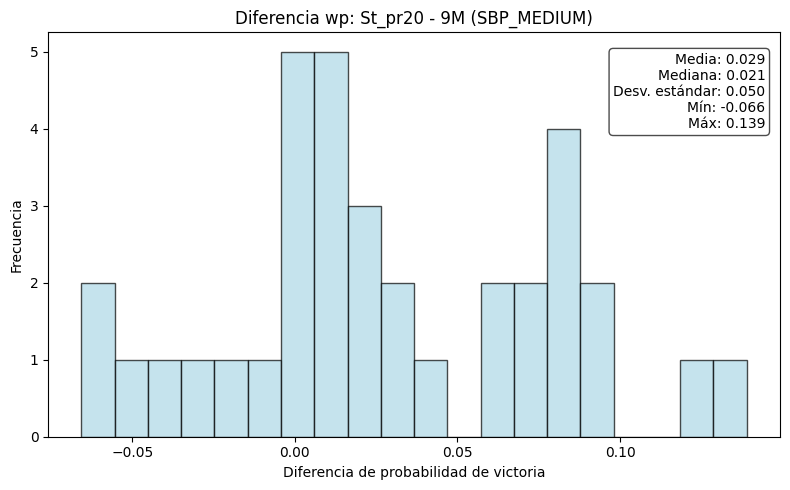

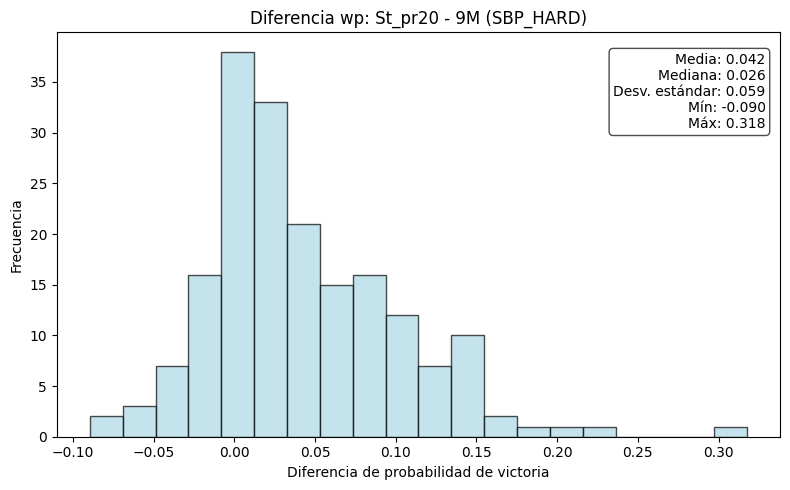

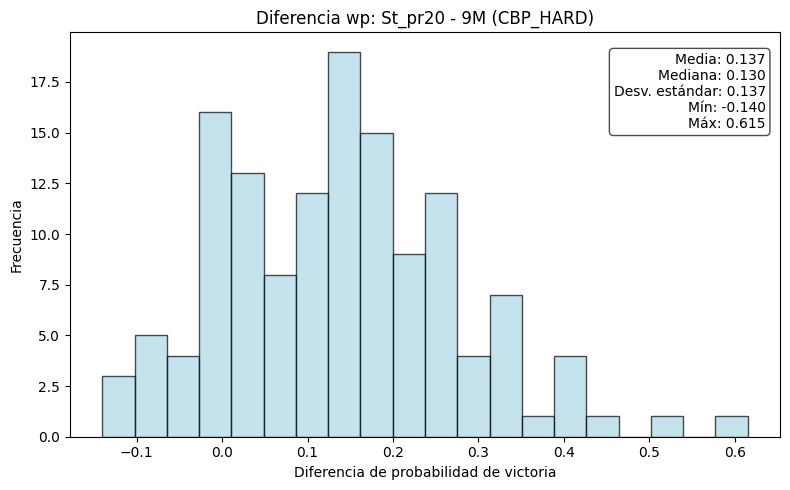

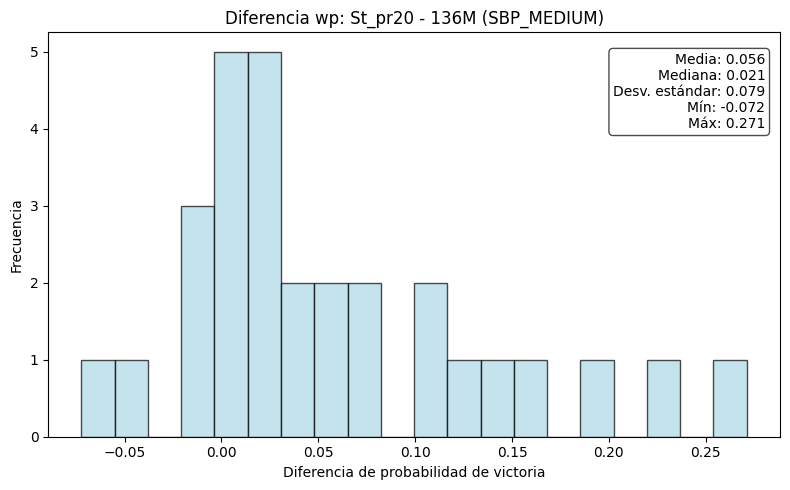

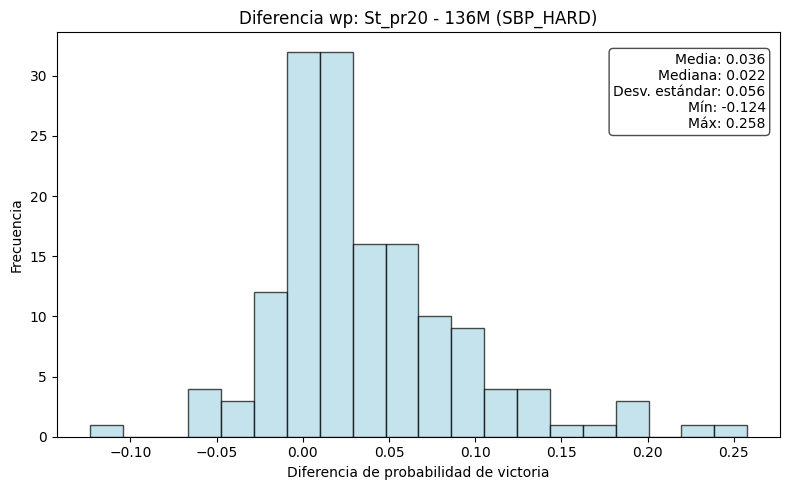

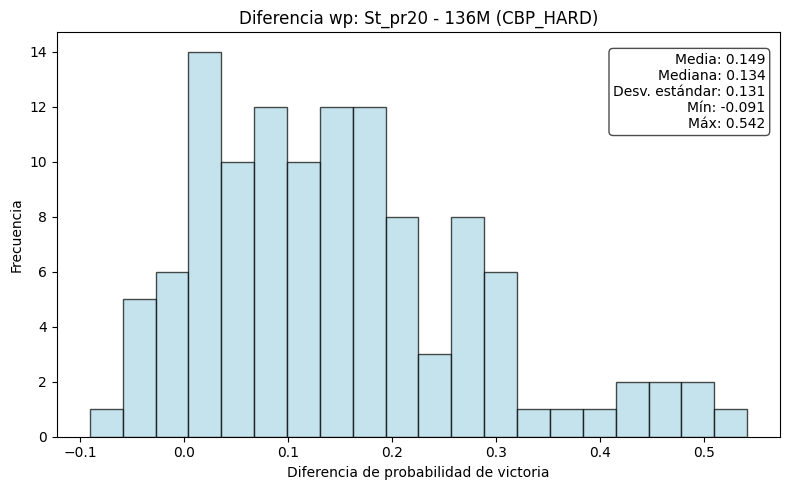

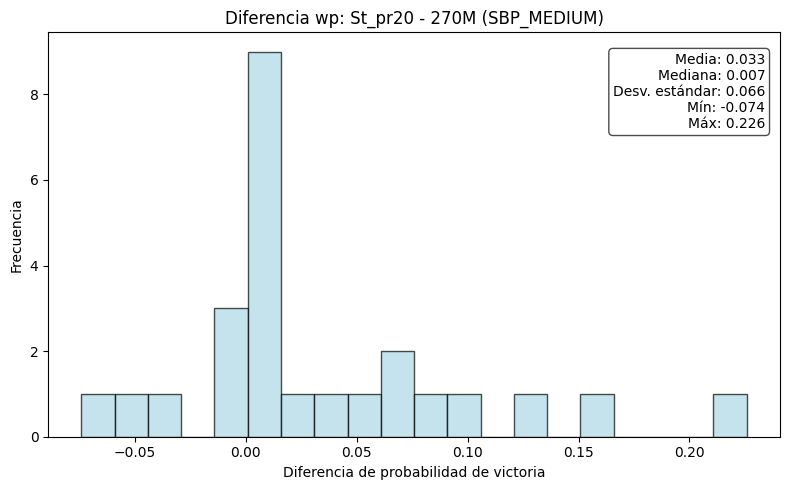

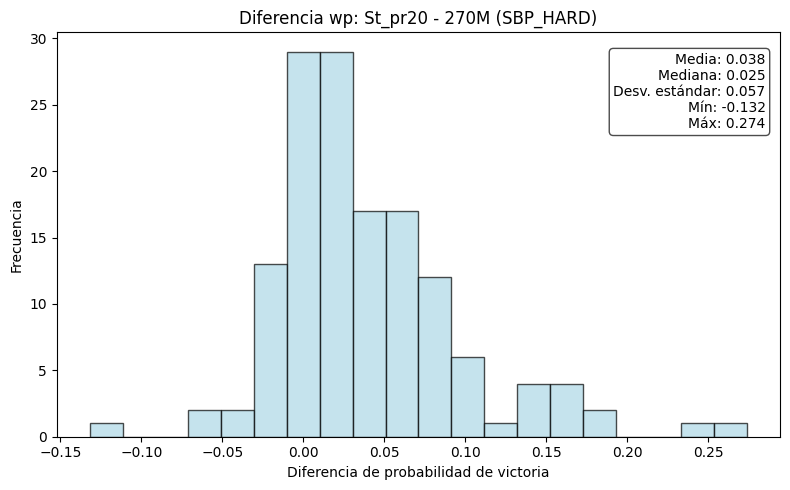

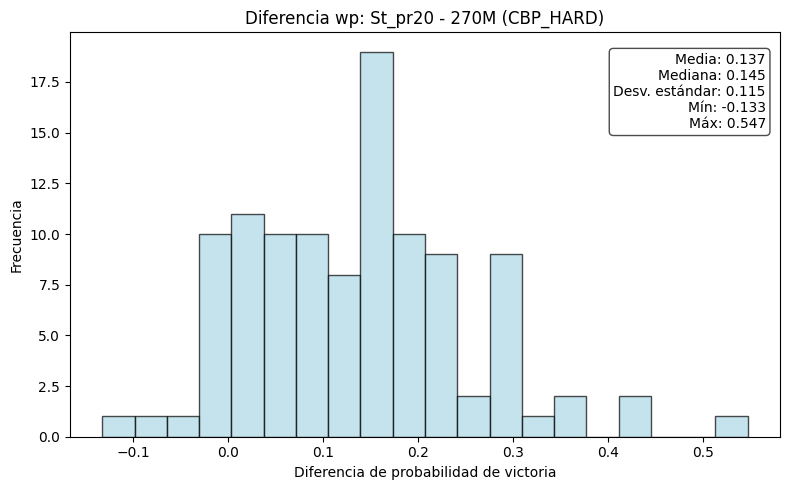

In [55]:
for modelo, datasets in diferencias_wp_con_stockfish.items():
    for df_name, diferencias in datasets.items():
        if not diferencias:
            print(f"[SKIP] {modelo} - {df_name}: diferencias vacías o None")
            continue

        for stockfish_key in [ 'St_pr20']:   #,'St0.05'
            difs = diferencias.get(stockfish_key)

            # Asegurar que existan datos válidos
            if not difs or all(d is None for d in difs):
                print(f"[SKIP] {modelo} - {df_name} - {stockfish_key}: sin datos válidos")
                continue

            # Limpiar Nones por si acaso
            difs_limpias = [d for d in difs if d is not None]

            # Calcular estadísticos
            media = np.mean(difs_limpias)
            mediana = np.median(difs_limpias)
            std = np.std(difs_limpias)
            minimo = np.min(difs_limpias)
            maximo = np.max(difs_limpias)

            plt.figure(figsize=(8, 5))
            plt.hist(difs_limpias, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
            plt.title(f"Diferencia wp: {stockfish_key} - {modelo} ({df_name})")
            plt.xlabel("Diferencia de probabilidad de victoria")
            plt.ylabel("Frecuencia")

            # Agregar estadísticas al gráfico
            stats_text = (f"Media: {media:.3f}\n"
                          f"Mediana: {mediana:.3f}\n"
                          f"Desv. estándar: {std:.3f}\n"
                          f"Mín: {minimo:.3f}\n"
                          f"Máx: {maximo:.3f}")
            
            plt.text(0.98, 0.95, stats_text,
                     transform=plt.gca().transAxes,
                     verticalalignment='top',
                     horizontalalignment='right',
                     bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

            plt.tight_layout()
            plt.show()

In [58]:
tabla_diferencias = []

for modelo, datasets in diferencias_wp_con_stockfish.items():
    for df_name, difs_dict in datasets.items():
        row = [df_name, modelo]

        if difs_dict is None:
            # Si no hay datos, añadimos None para todas las columnas
            row += [None, None, None, None]
        else:
            for clave in ['St0.05', 'St_pr20']:
                difs = difs_dict.get(clave)

                # Validar y limpiar la lista
                if not difs or not isinstance(difs, list):
                    row += [None, None]
                else:
                    difs_limpios = [d for d in difs if d is not None]
                    if not difs_limpios:
                        row += [None, None]
                    else:
                        row += [round(np.mean(difs_limpios), 4), round(np.max(difs_limpios), 4)]

        tabla_diferencias.append(row)

# Encabezados para tabulate
headers = [
    "df_name", "modelo",
    "diff_wp_St0.05_media", "diff_wp_St0.05_max",
    "diff_wp_St_pr20_media", "diff_wp_St_pr20_max"
]

# Mostrar tabla
print(tabulate(tabla_diferencias, headers=headers, tablefmt="fancy_grid"))

╒════════════╤══════════╤════════════════════════╤══════════════════════╤═════════════════════════╤═══════════════════════╕
│ df_name    │ modelo   │   diff_wp_St0.05_media │   diff_wp_St0.05_max │   diff_wp_St_pr20_media │   diff_wp_St_pr20_max │
╞════════════╪══════════╪════════════════════════╪══════════════════════╪═════════════════════════╪═══════════════════════╡
│ SBP_MEDIUM │ 9M       │                 0.0269 │               0.0962 │                  0.0287 │                0.1389 │
├────────────┼──────────┼────────────────────────┼──────────────────────┼─────────────────────────┼───────────────────────┤
│ SBP_HARD   │ 9M       │                 0.0358 │               0.2364 │                  0.0415 │                0.3177 │
├────────────┼──────────┼────────────────────────┼──────────────────────┼─────────────────────────┼───────────────────────┤
│ CBP_HARD   │ 9M       │                 0.1055 │               0.5685 │                  0.137  │                0.6151 │
├───────

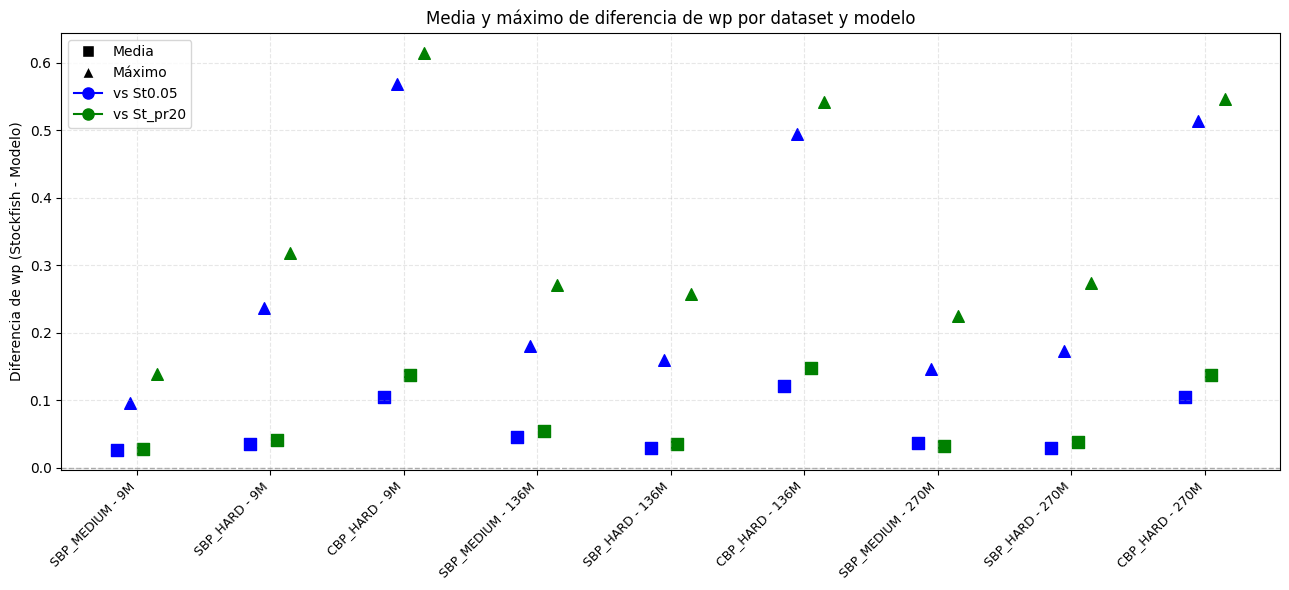

In [64]:
x_positions = []
y_values = []
colors = []
markers = []
x_map = {}
x_labels = []
x_index = 0

for row in tabla_diferencias:
    df_name, modelo, media_005, max_005, media_20, max_20 = row
    label = f"{df_name} - {modelo}"

    if label not in x_map:
        x_map[label] = x_index
        x_labels.append(label)
        x_index += 1

    pos = x_map[label]

    # St0.05
    if media_005 is not None:
        x_positions.append(pos - 0.15)
        y_values.append(media_005)
        colors.append('blue')
        markers.append('s')  # cuadrado = media

    if max_005 is not None:
        x_positions.append(pos - 0.05)
        y_values.append(max_005)
        colors.append('blue')
        markers.append('^')  # triángulo = máximo

    # St_pr20
    if media_20 is not None:
        x_positions.append(pos + 0.05)
        y_values.append(media_20)
        colors.append('green')
        markers.append('s')

    if max_20 is not None:
        x_positions.append(pos + 0.15)
        y_values.append(max_20)
        colors.append('green')
        markers.append('^')

# Crear figura
plt.figure(figsize=(13, 6))

# Dibujar los puntos con colores y marcadores
for x, y, c, m in zip(x_positions, y_values, colors, markers):
    plt.scatter(x, y, color=c, marker=m, s=70)

# Etiquetas del eje X
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right', fontsize=9)

# Detalles visuales
plt.ylabel("Diferencia de wp (Stockfish - Modelo)")
plt.title("Media y máximo de diferencia de wp por dataset y modelo")
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)

# Leyenda personalizada
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', label='Media', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Máximo', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='o', color='blue', label='vs St0.05', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='green', label='vs St_pr20', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

La forma de interpretar la gráfica es tomar la tupla (forma,color) e interpretar. Por ejemplo, (cuadrado,azul) es la media de diferencias de probabilidades con Stockfish a tiempo 0.05s.